In [1]:
# Importing tools from the notebook forward_curve_tools
%run forward_curve_new_tools.ipynb

### DATA

In [2]:
# Size of the data
train_size = 60000; # Size of the training set
test_size = 6000; # Size of the test set
calibration_size = test_size;
param_in = 9; # Input size to the neural network
parameter_cal = 7; # Size of training variables

l = 1/12 # 1 month of delivery, fixed
# NOTE: T_1 = tau, assumption for all the experiments

params_range = np.loadtxt('features_range_local_experiment_pointwise.dat')
vol = np.loadtxt('vol_local_experiment_pointwise.dat')
price = np.loadtxt('price_local_experiment_pointwise.dat')

In [3]:
# Train and test sets
params_range_train = params_range[np.arange(train_size), :] # size=[train_size, param_in]
params_range_test = params_range[train_size + np.arange(test_size), :] # size=[test_size, param_in]

price_train = price[np.arange(train_size)] # size=train_size
price_test = price[train_size + np.arange(test_size)] # size=test_size

# Calibration set
price_cal = price_test
params_cal = params_range_test

## FIRST STEP

In [7]:
EPOCHS = 200;        # Number of steps training
batch_size = 30;

patience = 20
delta = 0.0002

# To speed up training we need to create a some object which can send the data 
# fast to the GPU. Notice that they depend on the bactch_size
train_ds = tf.data.Dataset.from_tensor_slices(
              (params_range_train, price_train)).shuffle(10000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((params_range_test, price_test)).batch(batch_size)  

# Define the neural network. There are many possibilites here.
print('Initializing model')

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='relu');
        self.dense2 = tf.keras.layers.Dense(50, activation='relu');
        #self.dense3 = tf.keras.layers.Dense(50, activation='relu')
        self.dense4 = tf.keras.layers.Dense(1, activation = None)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        #x = self.dense3(x)
        x = self.dense4(x)
        return x

# Create an instance of the model
model = MyModel()

# Choose optimizer and type of loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError();

Initializing model


In [24]:
model.compile(loss = loss_object,
              optimizer = optimizer)
print(param_in)

9


In [22]:
model.build(input_shape = (param_in,1))

In [25]:
#model.save_weights('opt_weight_pointwise_with_NS.h5')
model.load_weights('opt_weight_pointwise_with_NS.h5')

ValueError: Shapes (1, 50) and (9, 50) are incompatible

In [38]:
price_predicted_train = model(params_range_train).numpy()
price_predicted_test = model(params_range_test).numpy()

In [39]:
err_training_train = abs(price_predicted_train-price_train)/price_train
err_training_test = abs(price_predicted_test-price_test)/price_test

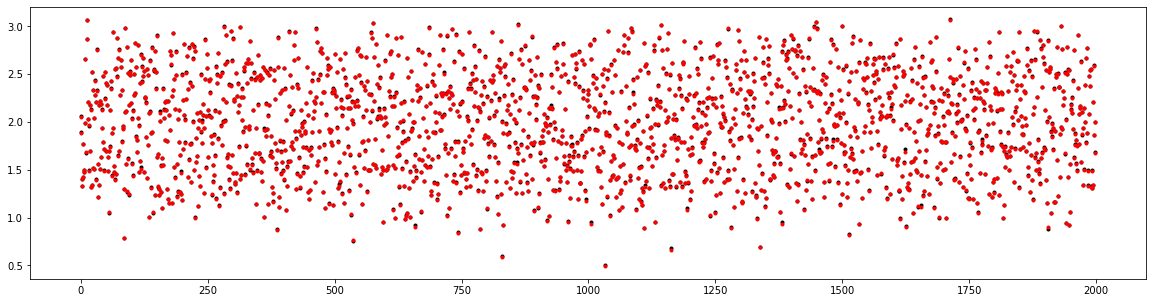

In [40]:
N = 2000
plt.figure(figsize = (20,5))
plt.plot(np.arange(N), price_predicted_train[np.arange(N)], '.k')
plt.plot(np.arange(N), price_train[np.arange(N)], '.r')

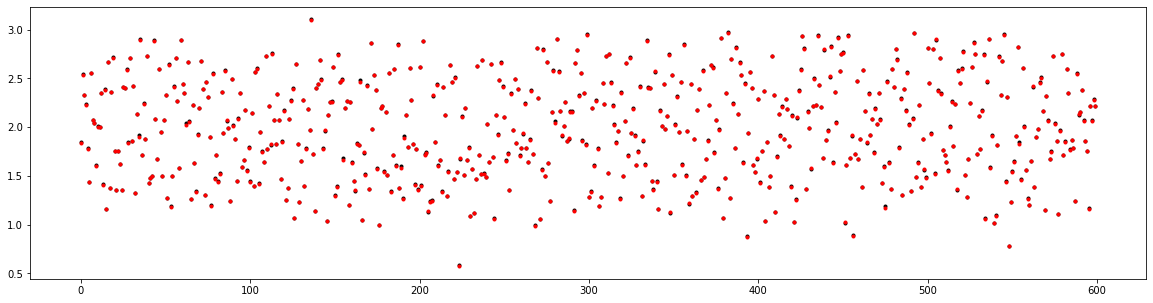

In [41]:
N = 600
plt.figure(figsize = (20,5))
plt.plot(np.arange(N), price_predicted_test[np.arange(N)], '.k')
plt.plot(np.arange(N), price_test[np.arange(N)], '.r')

 ...]

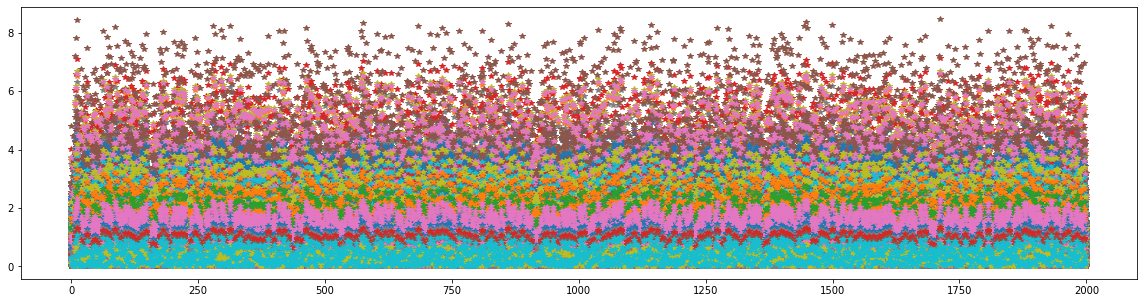

In [42]:
N = 2000
plt.figure(figsize = (20,5))
plt.plot(err_training_train[np.arange(N)+1], '*')
#plt.bar(np.arange(N, N+10), err_training_train[np.arange(N, N+10)+1,j,k])

In [43]:
K_vector = np.array([31.6, 32.65, 32.75, 32.85, 32.95, 33.05, 33.15, 33.2])
tau_vector = np.array([1/12, 1/12+1/24, 2/12+1/24, 3/12+1/24, 4/12+1/24, 5/12+1/24, 6/12+1/24, 1])
N1 = len(K_vector)-1
N2 = len(tau_vector)-1 


In [44]:
mean_square_err_training_train = np.zeros((N1,N2))
max_square_err_training_train = np.zeros((N1,N2))
for k in np.arange(N2):
    for j in np.arange(N1):
        pos_K = (params_range_train[:,0]>= K_vector[j])*(params_range_train[:,0]< K_vector[j+1])
        pos_tau = (params_range_train[:,1]>= tau_vector[k])*(params_range_train[:,1]< tau_vector[k+1])
        mean_square_err_training_train[j,k] = 100*np.mean(err_training_train[pos_K*pos_tau])
        max_square_err_training_train[j,k] = 100*np.max(err_training_train[pos_K*pos_tau])

In [45]:
mean_square_err_training_test = np.zeros((N1,N2))
max_square_err_training_test = np.zeros((N1,N2))
for k in np.arange(N2):
    for j in np.arange(N1):
        pos_K = (params_range_test[:,0]>= K_vector[j])*(params_range_test[:,0]< K_vector[j+1])
        pos_tau = (params_range_test[:,1]>= tau_vector[k])*(params_range_test[:,1]< tau_vector[k+1])
        mean_square_err_training_test[j,k] = 100*np.mean(err_training_test[pos_K*pos_tau])
        max_square_err_training_test[j,k] = 100*np.max(err_training_test[pos_K*pos_tau])

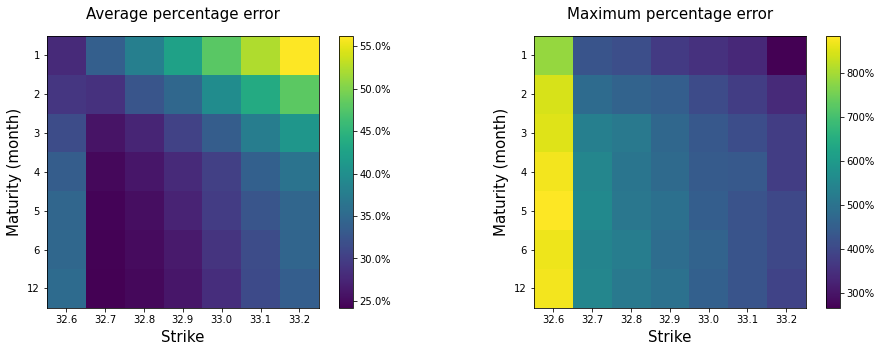

In [48]:
K_vector = np.array([32.6, 32.7, 32.8, 32.9, 33.0, 33.1, 33.2])

tau_label = ['1', '2', '3', '4', '5', '6', '12']
plt.figure(1,figsize=(16,5))

ax = plt.subplot(1,2,1)
#mean_err = np.mean(100*err_training_train,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_square_err_training_train))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
#max_err = np.max(100*err_training_train,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_square_err_training_train))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

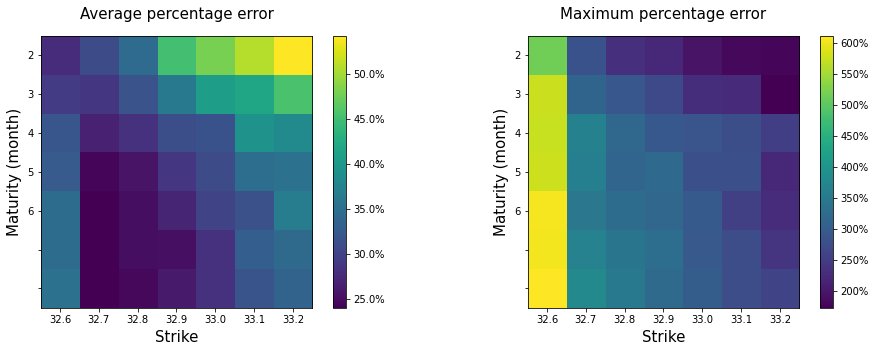

In [47]:
K_vector = np.array([32.6, 32.7, 32.8, 32.9, 33.0, 33.1, 33.2])

tau_label = ['2', '3', '4', '5', '6']
plt.figure(1,figsize=(16,5))

ax = plt.subplot(1,2,1)
#mean_err = np.mean(100*err_training_train,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_square_err_training_test))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
#max_err = np.max(100*err_training_train,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_square_err_training_test))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

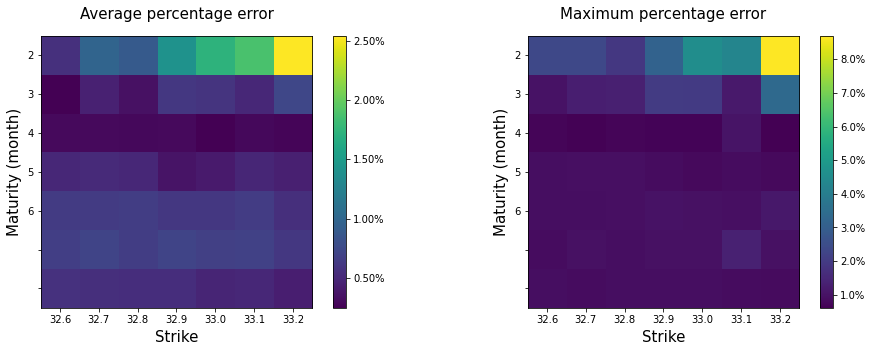

In [23]:
K_vector = np.array([32.6, 32.7, 32.8, 32.9, 33.0, 33.1, 33.2])

tau_label = ['2', '3', '4', '5', '6']
plt.figure(1,figsize=(16,5))

ax = plt.subplot(1,2,1)
#mean_err = np.mean(100*err_training_train,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_square_err_training_test))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
#max_err = np.max(100*err_training_train,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_square_err_training_test))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

#### Injectivity test

In [72]:
N_inj = 1000
params_range_inj = create_features_linspace(N = N_inj,
                                            v_min = [33.0, 3/12, 0.2, 0.5, 3], #[6, 0.2, 2] # [K, tau, a, b, k]
                                            v_max = [33.0, 3/12, 0.8, 0.5, 3]) #[8, 0.8, 4] # [K, tau, a, b, k]
price_inj = np.empty((N_inj,1))
for i in range(N_inj):
    model_features = params_range_inj[i,2:]
    s = uni_volatility_adj(model_features = model_features)
    K = params_range_inj[i,0]
    tau = params_range_inj[i,1]
    price_inj[i] = price_BS(option_features = np.array([K, tau, tau, l]),
                                    model_features = model_features)

price_predicted_inj = model(params_range_inj).numpy()

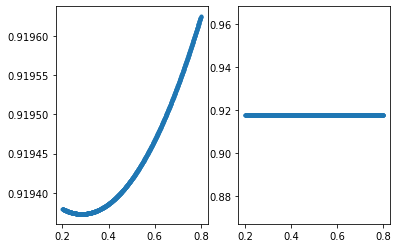

In [73]:
plt.subplot(1,2,1)
plt.plot(params_range_inj[:,2], price_predicted_inj, '.')
plt.subplot(1,2,2)
plt.plot(params_range_inj[:,2], price_inj, '.')

In [25]:
# The network is done training. We are ready to start on the Calibration step
print('\n\nCalibration step')

EPOCHS_CAL = 60     # Number of steps calebrating

# This does depend on the calibration size
cal_ds = tf.data.Dataset.from_tensor_slices(
              (price_cal)).batch(calibration_size)

input_fixed = params_cal[:,:2]
tf_input_fixed = tf.constant(input_fixed)

print('Compiling calibration step')
@tf.function
def calibration_step(input_guess, prices):
        
        with tf.GradientTape() as tape:
            tape.watch(input_guess)
            prediction = model(tf.concat([tf_input_fixed,input_guess], axis = 1))
            c_loss = loss_object(prices, prediction)
        calibration_loss(c_loss)
        grads = tape.gradient(c_loss, [input_guess])
        optimizer.apply_gradients(zip(grads, [input_guess]))

# We need to guess some initial model parameters.
input_guess = params_cal[:, 2:] + np.random.rand(calibration_size, parameter_cal)*np.array([0.05, 0.05, 0.5, 0.5, 0.05, 0.05, 0.05])
#np.matlib.repmat([0.5, 0.5, 5], m = (calibration_size), n = 1) # [a, b, k], size=[calibration_size, param_in]

# I just copy the starting parameters for convenience. This is not necessary
old_input_guess = input_guess.copy();

# Important: First convert to tensor, then to variable
tf_input_guess = tf.convert_to_tensor(input_guess)
tf_var_input_guess = tf.Variable(tf_input_guess);

# Start the actual calibration
for epoch in range(EPOCHS_CAL):
    calibration_loss.reset_states()
    for labels in cal_ds:
        # For each set of labels, compute the gradient of the network, and 
        # preform a gradient update on the input parameters. 
        calibration_step(tf_var_input_guess, labels)

    template = 'Epoch_cal {}, Loss: {}'
    print(template.format(epoch+1,
                          calibration_loss.result(),
                          ))

new_input_guess = tf_var_input_guess.numpy();

X = new_input_guess-old_input_guess
print(np.linalg.norm(X, 'fro'));



Calibration step
Compiling calibration step
Epoch_cal 1, Loss: 0.08128689229488373
Epoch_cal 2, Loss: 0.07935095578432083
Epoch_cal 3, Loss: 0.07674987614154816
Epoch_cal 4, Loss: 0.07376722991466522
Epoch_cal 5, Loss: 0.07056490331888199
Epoch_cal 6, Loss: 0.06725052744150162
Epoch_cal 7, Loss: 0.06390012055635452
Epoch_cal 8, Loss: 0.06056859344244003
Epoch_cal 9, Loss: 0.05729575455188751
Epoch_cal 10, Loss: 0.05411021038889885
Epoch_cal 11, Loss: 0.05103221535682678
Epoch_cal 12, Loss: 0.04807547852396965
Epoch_cal 13, Loss: 0.04524877294898033
Epoch_cal 14, Loss: 0.04255703464150429
Epoch_cal 15, Loss: 0.04000217095017433
Epoch_cal 16, Loss: 0.03758387267589569
Epoch_cal 17, Loss: 0.03530006483197212
Epoch_cal 18, Loss: 0.0331474170088768
Epoch_cal 19, Loss: 0.031121602281928062
Epoch_cal 20, Loss: 0.029217686504125595
Epoch_cal 21, Loss: 0.02743026241660118
Epoch_cal 22, Loss: 0.025753667578101158
Epoch_cal 23, Loss: 0.02418217994272709
Epoch_cal 24, Loss: 0.02271002158522606
E

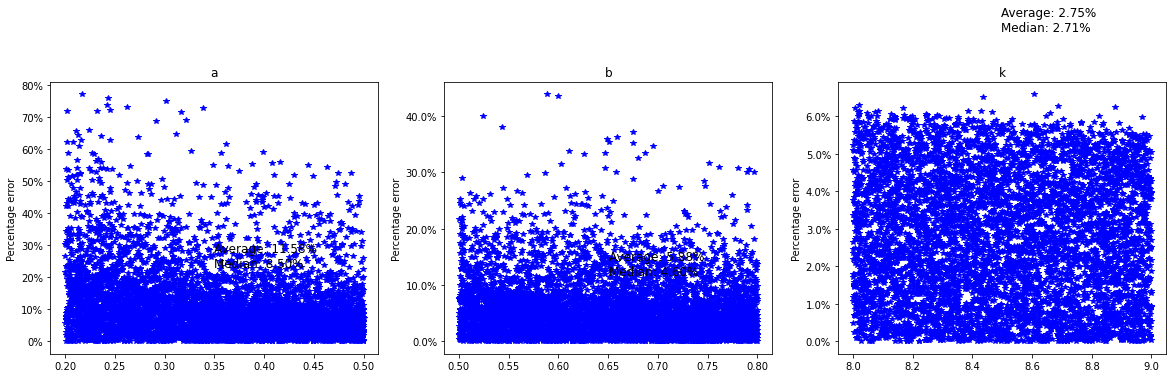

In [26]:
percentage_err = np.abs(new_input_guess-params_cal[:,2:])/params_cal[:,2:]
mean_percentage_err = np.mean(percentage_err, axis = 0)*100
percentage_err_copy = percentage_err.copy()
percentage_err_copy.sort(axis=0)
median_percentage_err = percentage_err_copy[calibration_size//2, :]*100

plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.plot(params_cal[:,2], percentage_err[:,0]*100, '*b')
plt.title('a')
plt.ylabel('Percentage error');
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
s0 = 'Average: %.2f' %mean_percentage_err[0] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[0] + r'%'
plt.text(np.mean(params_cal[:,2]), np.mean(percentage_err[:,0]*100)*2, s0, fontsize=12);

plt.subplot(1,3,2)
plt.plot(params_cal[:,3], percentage_err[:,1]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('b')
plt.ylabel('Percentage error');
s1 = 'Average: %.2f' %mean_percentage_err[1] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[1] + r'%'
plt.text(np.mean(params_cal[:,3]), np.mean(percentage_err[:,1]*100)*2, s1, fontsize=12);

plt.subplot(1,3,3)
plt.plot(params_cal[:,4], percentage_err[:,2]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('k')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[2] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[2] + r'%'
plt.text(np.mean(params_cal[:,4]), np.mean(percentage_err[:,2]*100)*3, s2, fontsize=12);

In [27]:
percentage_err = np.abs(new_input_guess-params_cal)/np.abs(params_cal)
mean_percentage_err = np.mean(percentage_err, axis = 0)*100
percentage_err_copy = percentage_err.copy()
percentage_err_copy.sort(axis=0)
median_percentage_err = percentage_err_copy[calibration_size//2, :]*100

plt.figure(figsize = (20,15))
plt.subplot(3,3,1)
plt.plot(params_cal[:,0], percentage_err[:,0]*100, '*b')
plt.title('a')
plt.ylabel('Percentage error');
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
s0 = 'Average: %.2f' %mean_percentage_err[0] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[0] + r'%'
plt.text(np.mean(params_cal[:,0]), np.mean(percentage_err[:,0]*100)*2, s0, fontsize=12);

plt.subplot(3,3,2)
plt.plot(params_cal[:,1], percentage_err[:,1]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('b')
plt.ylabel('Percentage error');
s1 = 'Average: %.2f' %mean_percentage_err[1] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[1] + r'%'
plt.text(np.mean(params_cal[:,1]), np.mean(percentage_err[:,1]*100)*2, s1, fontsize=12);

plt.subplot(3,3,3)
plt.plot(params_cal[:,2], percentage_err[:,2]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('k')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[2] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[2] + r'%'
plt.text(np.mean(params_cal[:,2]), np.mean(percentage_err[:,2]*100)*2, s2, fontsize=12);

plt.subplot(3,3,4)
plt.plot(params_cal[:,3], percentage_err[:,3]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_0$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[3] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[3] + r'%'
plt.text(np.mean(params_cal[:,3]), np.mean(percentage_err[:,3]*100)*2, s2, fontsize=12);

plt.subplot(3,3,5)
plt.plot(params_cal[:,4], percentage_err[:,4]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_1$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[4] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[4] + r'%'
plt.text(np.mean(params_cal[:,4]), np.mean(percentage_err[:,4]*100)*2, s2, fontsize=12);

plt.subplot(3,3,6)
plt.plot(params_cal[:,5], percentage_err[:,5]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_2$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[5] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[5] + r'%'
plt.text(np.mean(params_cal[:,5]), np.mean(percentage_err[:,5]*100)*2, s2, fontsize=12);

plt.subplot(3,3,7)
plt.plot(params_cal[:,6], percentage_err[:,6]*100, '*b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_3$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[6] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[6] + r'%'
plt.text(np.mean(params_cal[:,6]), np.mean(percentage_err[:,6]*100)*2, s2, fontsize=12);

ValueError: operands could not be broadcast together with shapes (6000,7) (6000,9) 

In [ ]:
price_predicted_cal = model(new_input_guess).numpy()
price_predicted_cal = np.squeeze(price_predicted_cal)

In [ ]:
err_training_cal = abs(price_predicted_cal-price_cal)/price_cal

In [ ]:
K_vector = np.array([31.6, 32.65, 32.75, 32.85, 32.95, 33.05, 33.15, 33.2])
tau_vector = np.array([1/12, 1/12+1/24, 2/12+1/24, 3/12+1/24, 4/12+1/24, 5/12+1/24, 6/12+1/24, 1])
N1 = len(K_vector)-1
N2 = len(tau_vector)-1 


In [ ]:
mean_square_err_training_train = np.zeros((N1,N2))
max_square_err_training_train = np.zeros((N1,N2))
for k in np.arange(N2):
    for j in np.arange(N1):
        pos_K = (params_range_train[:,0]>= K_vector[j])*(params_range_train[:,0]< K_vector[j+1])
        pos_tau = (params_range_train[:,1]>= tau_vector[k])*(params_range_train[:,1]< tau_vector[k+1])
        mean_square_err_training_train[j,k] = 100*np.mean(err_training_train[pos_K*pos_tau])
        max_square_err_training_train[j,k] = 100*np.max(err_training_train[pos_K*pos_tau])

In [ ]:
tau_label = ['2', '3', '4', '5', '6']
plt.figure(1,figsize=(16,5))

ax = plt.subplot(1,2,1)
mean_err = np.mean(100*err_training_cal,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_err))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
max_err = np.max(100*err_training_cal,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_err))
plt.colorbar(format = mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);